In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
from prophet import Prophet
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [16]:
paths = {
    "2005": "/content/accidents_2005_to_2007.csv",
    "2009": "/content/accidents_2009_to_2011.csv",
    "2012": "/content/accidents_2012_to_2014.csv",
}

frames = []
for year, path in paths.items():
    df_part = pd.read_csv(path, dtype='unicode')
    frames.append(df_part)

df = pd.concat(frames, ignore_index=True)

VERI ON ISLEME

In [18]:

# a) Tarih donusumu
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Year'] = df['Date'].dt.year

# b) Urban-Rural donusumu
area_map = {'1': 'Urban', '2': 'Rural', '3': 'Unknown'}
df['Area_Type'] = df['Urban_or_Rural_Area'].map(area_map)

# c) Kaza siddeti etiketi
severity_map = {'1': 'Fatal', '2': 'Serious', '3': 'Slight'}
df['Severity_Label'] = df['Accident_Severity'].map(severity_map)

# d) Eksik veri analizi
missing = df.isnull().sum()
print("Eksik veriler (ilk 10):\n", missing[missing > 0].sort_values(ascending=False).head(10))

Eksik veriler (ilk 10):
 Junction_Detail                                1504150
Carriageway_Hazards                            1476900
Special_Conditions_at_Site                     1467568
Year                                            905588
Date                                            905588
Junction_Control                                602835
LSOA_of_Accident_Location                       108238
Did_Police_Officer_Attend_Scene_of_Accident       2922
Road_Surface_Conditions                           1958
Weather_Conditions                                 126
dtype: int64


YILLARA GORE KAZA SAYISI

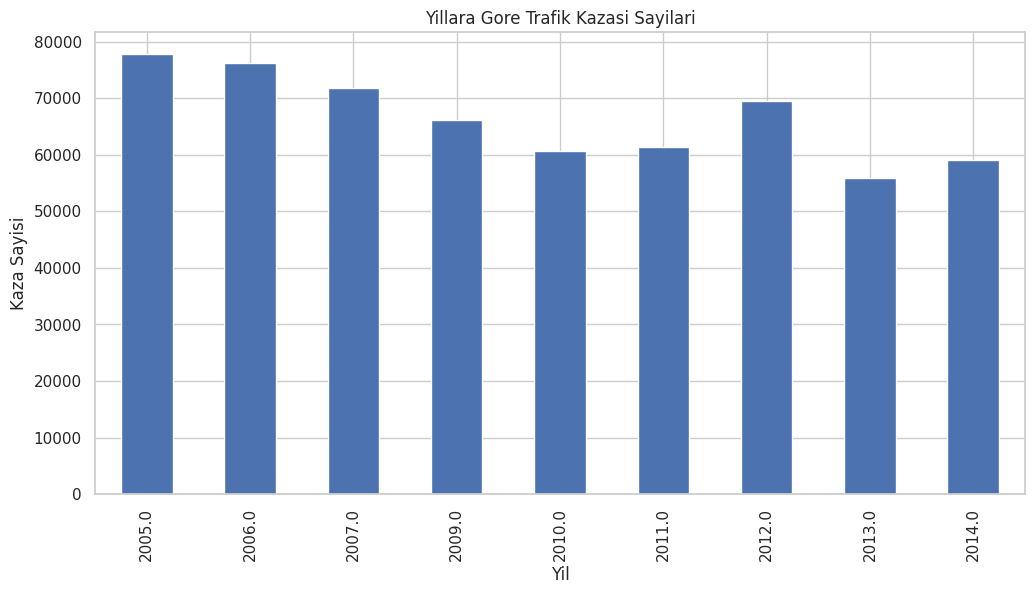

In [19]:
yearly_counts = df['Year'].value_counts().sort_index()
yearly_counts.plot(kind='bar')
plt.title("Yillara Gore Trafik Kazasi Sayilari")
plt.xlabel("Yil")
plt.ylabel("Kaza Sayisi")
plt.show()

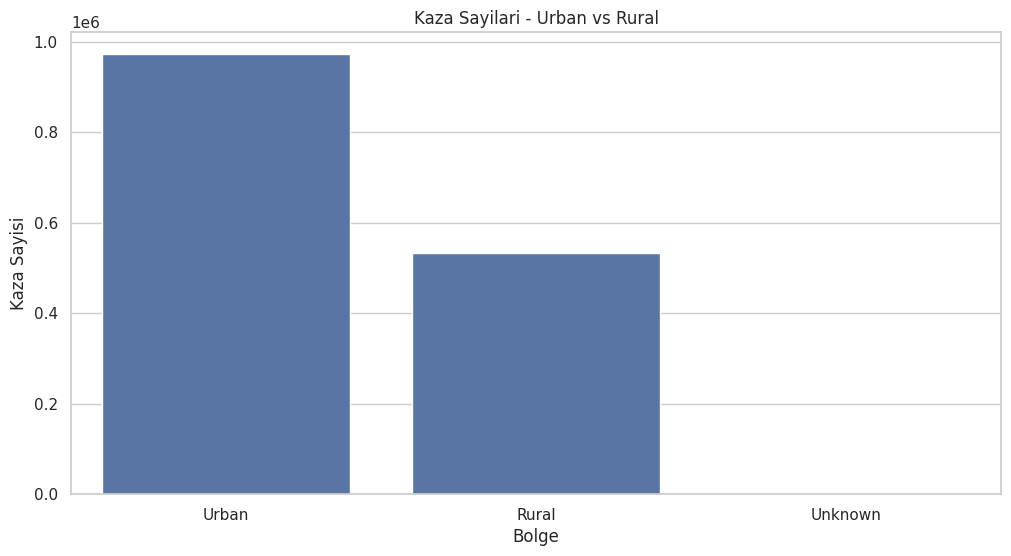

In [20]:
sns.countplot(data=df, x='Area_Type', order=['Urban', 'Rural', 'Unknown'])
plt.title("Kaza Sayilari - Urban vs Rural")
plt.xlabel("Bolge")
plt.ylabel("Kaza Sayisi")
plt.show()


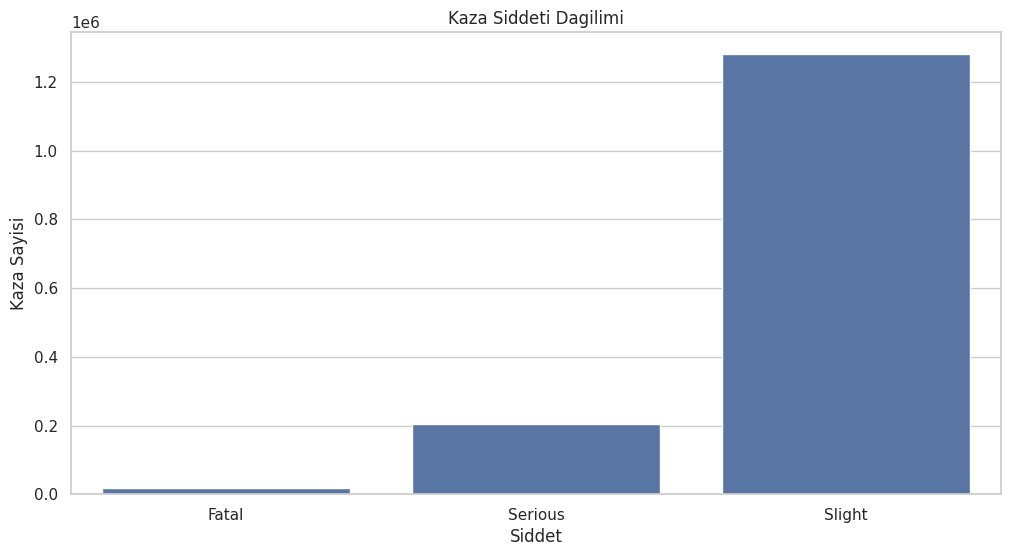

In [21]:
sns.countplot(data=df, x='Severity_Label', order=['Fatal', 'Serious', 'Slight'])
plt.title("Kaza Siddeti Dagilimi")
plt.xlabel("Siddet")
plt.ylabel("Kaza Sayisi")
plt.show()

In [22]:
if {'Latitude', 'Longitude'}.issubset(df.columns):
    df_map = df[['Latitude', 'Longitude', 'Severity_Label']].dropna().sample(10000)
    df_map['Latitude'] = df_map['Latitude'].astype(float)
    df_map['Longitude'] = df_map['Longitude'].astype(float)
    fig = px.scatter_mapbox(df_map, lat="Latitude", lon="Longitude",
                            color="Severity_Label", zoom=5,
                            mapbox_style="open-street-map",
                            title="Kaza Noktalari Haritasi")
    fig.show()

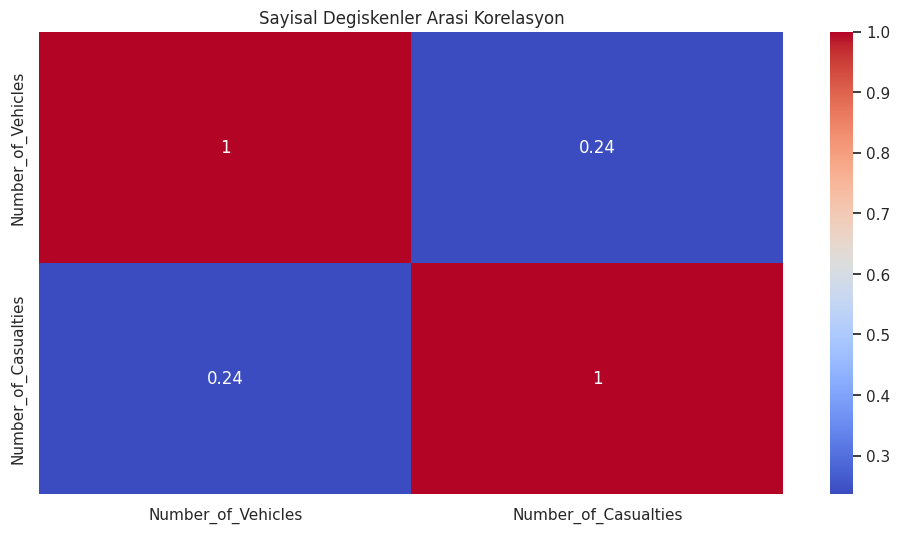

In [23]:
numeric_cols = ['Number_of_Vehicles', 'Number_of_Casualties']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Sayisal Degiskenler Arasi Korelasyon")
plt.show()

Zaman Serisi

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 6.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpef2wp5y1/6z96jyig.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpef2wp5y1/zrnucmn3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29641', 'data', 'file=/tmp/tmpef2wp5y1/6z96jyig.json', 'init=/tmp/tmpef2wp5y1/zrnucmn3.json', 'output', 'file=/tmp/tmpef2wp5y1/prophet_modelgt4rcge_/prophet_model-20250701102525.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:25:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:25:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

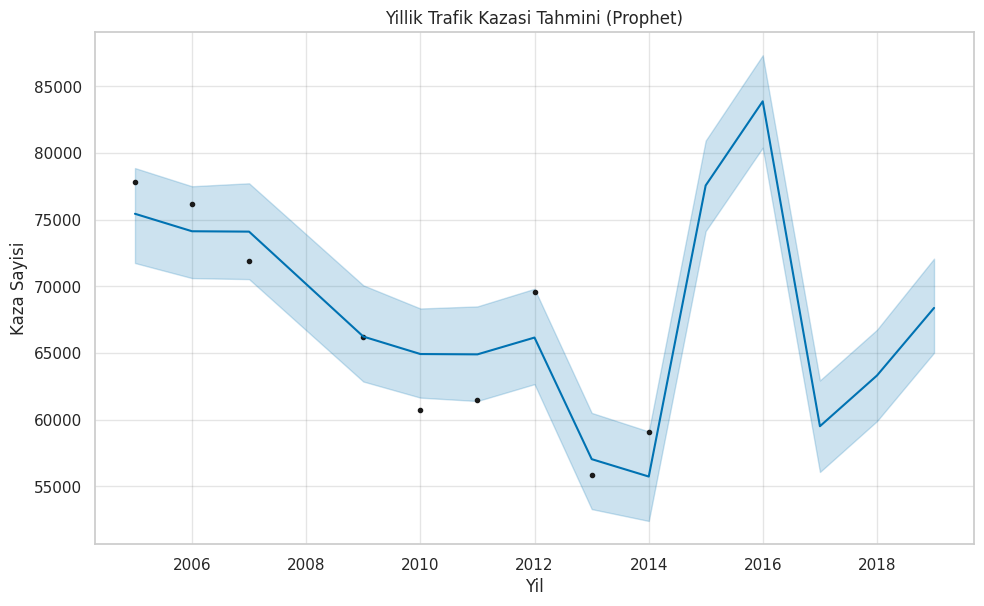

In [24]:
yearly_df = df['Date'].dt.to_period('Y').value_counts().sort_index().reset_index()
yearly_df.columns = ['ds', 'y']
yearly_df['ds'] = yearly_df['ds'].dt.to_timestamp()

model = Prophet()
model.fit(yearly_df)

future = model.make_future_dataframe(periods=5, freq='Y')  # 5 yil ileri (2015-2019)
forecast = model.predict(future)

model.plot(forecast)
plt.title("Yillik Trafik Kazasi Tahmini (Prophet)")
plt.xlabel("Yil")
plt.ylabel("Kaza Sayisi")
plt.show()